# Import

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime, timedelta, date
from sklearn import preprocessing

import plotly.graph_objects as go

# pandas max row 
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

# Data Load

- 시간 전처리: index화 + datatime 변형
- 시간 보정 작업: index 기준 나머지 
- 소수점 변환: 용해 온도, 교반속도 소수점 변환

In [ ]:
## 최초 dataset 아래와 같음
df = pd.read_csv('경진대회용 용해탱크 데이터셋.csv', encoding='cp949') 

# 시간 정보 각 index별 6초 단위 값 삽입
def num_change(x):
    remainder = divmod(x, 10)[1]
    change_second = remainder * 6
    
    if len(str(change_second)) == 1:
        value = '0' + str(change_second)
    else: 
        value = str(change_second)
    
    return value
df['NUM'] = df['NUM'].agg(lambda x: num_change(x))

df_cp = df.copy()
df_cp['STD_DT'] = df_cp['STD_DT'] + ':' + df_cp['NUM']

# 시간 정보 : object => datatime으로 변형 / index화
df_cp['STD_DT'] = df_cp['STD_DT'].apply(lambda x : pd.to_datetime(str(x), format='%Y-%m-%d %H:%M:%S'))

# Data Preprocessing

In [17]:
df_cp = df_cp.set_index(['STD_DT'])

## 소수점 변환: 용해 온도(MELT_TEMP), 교반속도(MOTORSPEED)
def change_value(x):
    operation_value = str(x)             # str 형식으로 변환
    length_value = len(operation_value)  # 길이 확인

    if length_value == 1:
        value = '0.' + operation_value
    elif length_value == 2:
        value = operation_value[0] + '.' + operation_value[1]
    else: 
        int_cnt = length_value - 1
        value = operation_value[:int_cnt] + '.' + operation_value[int_cnt]
        

    change_value = float(value)
    return change_value

df_cp['MELT_TEMP'] = df_cp['MELT_TEMP'].agg(lambda x: change_value(x))
df_cp['MOTORSPEED'] = df_cp['MOTORSPEED'].agg(lambda x: change_value(x))

del df_cp['NUM']

df_cp.head(20)

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
STD_DT,,,,,
2020-03-04 00:00:00,48.9,11.6,631.0,3.19,OK
2020-03-04 00:00:06,43.3,7.8,609.0,3.19,OK
2020-03-04 00:00:12,46.4,15.4,608.0,3.19,OK
2020-03-04 00:00:18,37.9,21.2,606.0,3.19,OK
2020-03-04 00:00:24,79.8,173.6,604.0,3.21,OK
2020-03-04 00:00:30,74.3,172.2,603.0,3.21,OK
2020-03-04 00:00:36,39.0,21.2,602.0,3.19,OK
2020-03-04 00:00:42,49.3,15.2,600.0,3.19,OK
2020-03-04 00:00:48,42.7,0.0,599.0,3.19,OK


##### 중간과정
- 앞선 전처리 과정 이외의 다른 팀원들이 진행했던 전처리 정보를 기반으로 Data 불러옴
- 추가 데이터 작업 진행 : 

In [38]:
train = pd.read_csv('train_time_data_pf.csv', index_col = 1)
test = pd.read_csv('validation_time_data_pf.csv', index_col = 1)

value = pd.concat([train,test])
value_cp = value.reset_index(drop = True)
value_cp['STD_DT'] = value_cp['STD_DT'].apply(lambda x : pd.to_datetime(str(x), format='%Y-%m-%d %H:%M:%S'))
value_cp = value_cp.set_index('STD_DT')

value_cp.head()

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,Measurement_error,MW_Period_Second,TAG
STD_DT,,,,,,,
2020-03-04 00:00:00,48.9,11.6,631.0,3.19,0,912,0
2020-03-04 00:00:06,43.3,7.8,609.0,3.19,0,912,0
2020-03-04 00:00:12,46.4,15.4,608.0,3.19,0,912,0
2020-03-04 00:00:18,37.9,21.2,606.0,3.19,0,912,0
2020-03-04 00:00:24,79.8,173.6,604.0,3.21,0,912,0


# EDA

#### [1] 불량과 정상 사이의 분포도 확인 
- Motospped(교반속도), MELT_TEMP(융해온도)가 높을 때의 경우 불량이 없음 => 이들에 대한 상관관계가 존재할까 확인

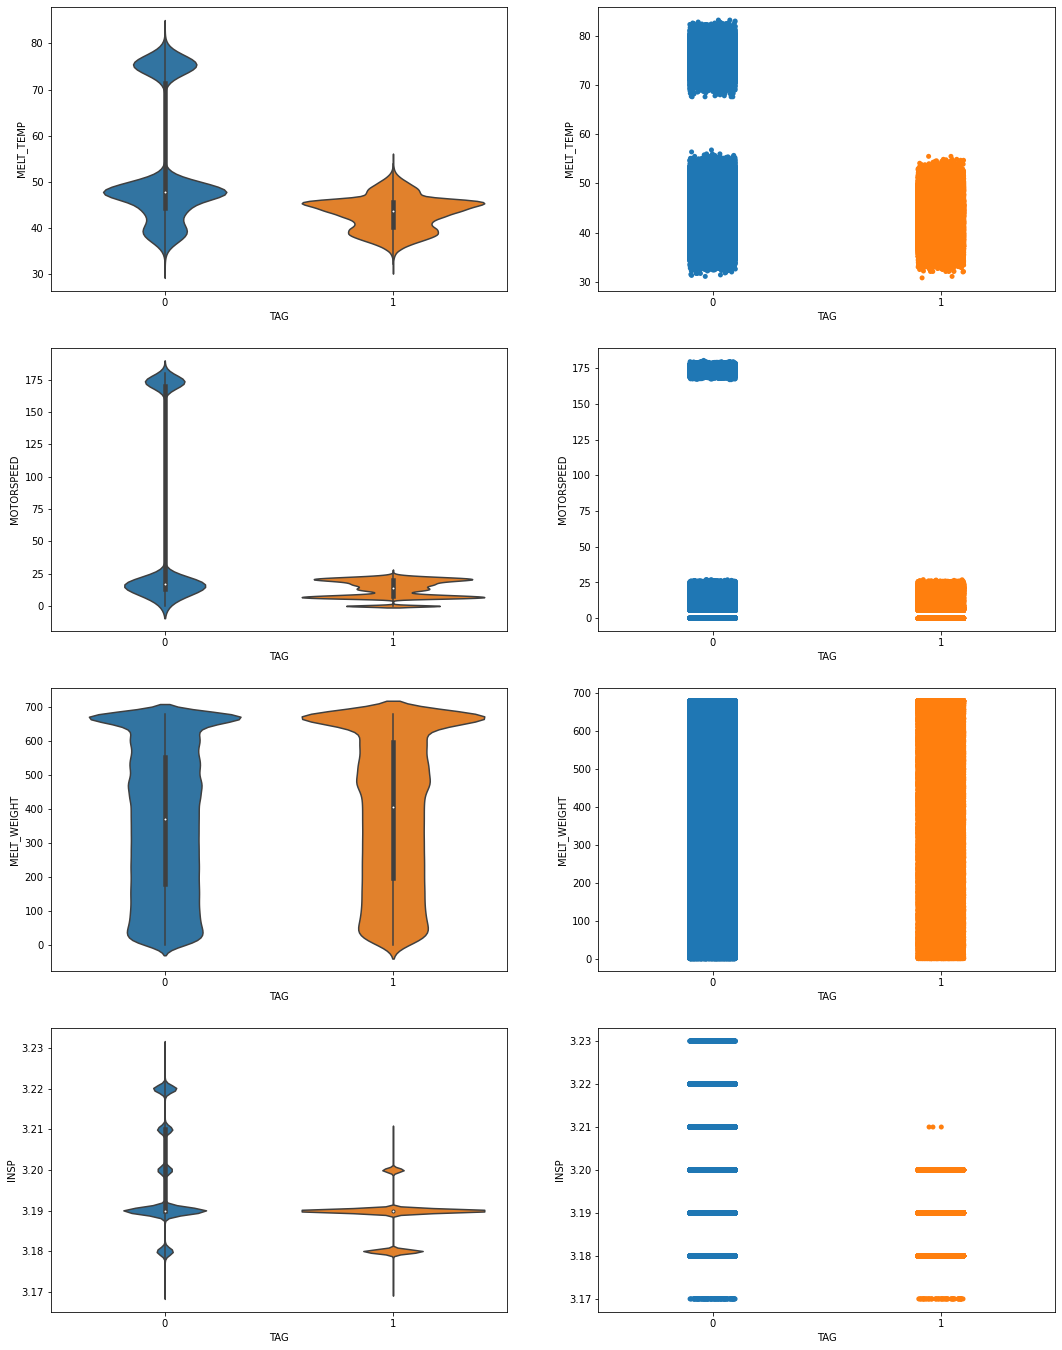

In [39]:
fig, ax = plt.subplots(4, 2, figsize = (18,24))
sns.violinplot(x='TAG', y='MELT_TEMP', data = value_cp, ax = ax[0,0])
sns.stripplot(x='TAG', y='MELT_TEMP', data = value_cp, ax = ax[0,1])

sns.violinplot(x='TAG', y='MOTORSPEED', data = value_cp, ax = ax[1,0])
sns.stripplot(x='TAG', y='MOTORSPEED', data = value_cp, ax = ax[1,1])

sns.violinplot(x='TAG', y='MELT_WEIGHT', data = value_cp, ax = ax[2,0])
sns.stripplot(x='TAG', y='MELT_WEIGHT', data = value_cp, ax = ax[2,1])

sns.violinplot(x='TAG', y='INSP', data = value_cp, ax = ax[3,0])
sns.stripplot(x='TAG', y='INSP', data = value_cp, ax = ax[3,1])
plt.show()

#### 상관관계 Plot
- 용해 온도와 교반 속도, 수분 함유량간의 양의 상관관계가 높음 
(수분 함유량의 경우 숫자로 되어있는 category)

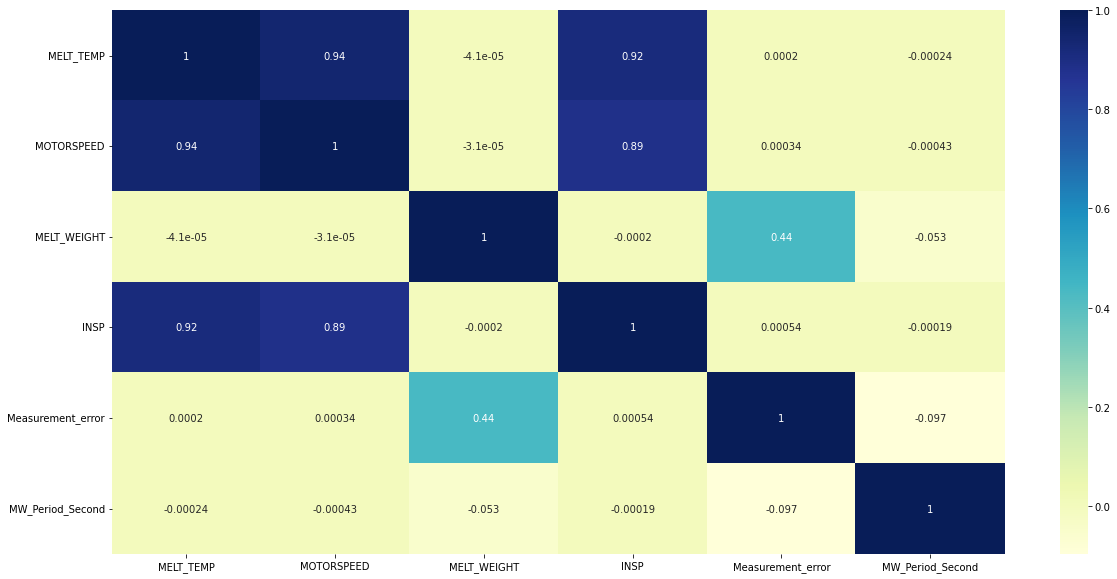

In [40]:
plt.figure(figsize=(20,10))
sns.heatmap(value_cp.iloc[:,:-1].corr(), annot=True, cmap="YlGnBu")
plt.show()

#### 분단위 데이터 셋 만들기

- ML 돌릴 때 분 단위로 예측하는 방향으로 진행 
- 1분 Cycle 내에서 한 번이라도 고장이 발생하면 => 고장으로 Label 진행 
- Feautre는 각 초(6,12,18,24,30,36,42,48,54)마다의 feature 정보를 줌: 

In [48]:
df_procssing = value_cp.copy()

# ML 만들기 위한 Dataset 전처리
## (1) 분 단위 이상치 정의 
#df_procssing['TAG'] = df_procssing['TAG'].agg(lambda x: 0 if x == "OK" else 1)  # 각 Tag를 index화 진행
df_byminute = df_procssing['TAG'].resample('T').sum()                             # 분마다 정상/비정상의 개수 확인

# 비율 52;48
ML_1min = pd.DataFrame(df_byminute)                                               # DataFrame화
ML_1min['TAG'] = ML_1min['TAG'].agg(lambda x: 0 if x == 0 else 1)               # 분 단위 이상치 中 1번이라도 이상이 발생할 경우 => 이상으로 판단

## (2) 분 단위 cycle feature 생성
from tqdm import tqdm
cnt = df_procssing.shape[0]
minute_result = {}                                                                # 분단위 feature 저장할 dictionary(key: 날싸 + 시간, value: list(1분 cycle마다의 제조 설비 정보))
title_list = []                                                                   # 분단위 feature dataframe에 대한 제목 저장할 list 

for idx in tqdm(range(cnt)):
    
    # 각 분 단위로 저장할 result 초기화 코드
    if idx == 0 :                       # 최초의 result는 초기화(공란)
        result = []  
    elif idx % 10 == 0 :  # 최초 이외의 10단위(분단위가 바뀌는 시점) 이거나 마지막 단위는 dicionary에 저장
        minute_result[day] = result 
        result = []
    
    # 각 Cycle 단위 당 feature 정보 저장
    melt_temp = df_procssing['MELT_TEMP'][idx]
    moto_speed = df_procssing['MOTORSPEED'][idx]
    melt_weight = df_procssing['MELT_WEIGHT'][idx]
    insp = df_procssing['INSP'][idx]
    ME = df_procssing['Measurement_error'][idx]
    MW = df_procssing['MW_Period_Second'][idx]
    
    # 결과값을 저장
    result.extend([melt_temp, moto_speed, melt_weight, insp, ME, MW])
    
    # dataframe의 저장할 feature 이름 생성
    if idx <= 9:
        for name in list(df_procssing.columns[:-1]):
            second = str(df_procssing.reset_index()['STD_DT'].dt.second[idx])
            
            if len(second) == 1:
                second = '0' + second  
            
            change_title = name + '_' + second
            title_list.append(change_title)
    
    # 분마다의 feature를 matching 시키기 위한 key 값 생성
    if idx % 10 == 9:
        ts = df_procssing.reset_index()['STD_DT'][idx]
        day = ts.strftime('%Y-%m-%d %H:%M')
        
    # 마지막 분에 데이터 저장
    if idx == (cnt - 1):
        minute_result[day] = result 
        
# 데이터 frame 화
day_point = pd.DataFrame(minute_result).T
day_point.columns = title_list
day_point = day_point.reset_index()

day_point['index'] = day_point['index'].apply(lambda x : pd.to_datetime(str(x), format='%Y-%m-%d %H:%M')) # str => timedelt 변환
day_point = day_point.rename(columns = {'index' : 'STD_DT'})                                               # 분 index columen명 변경

## (3) 2개의 dataFrame 추가
ML_data = pd.merge(day_point, ML_1min, on ='STD_DT')
ML_data = ML_data.set_index('STD_DT')
ML_data.to_csv('data_renew.csv')

100%|█████████████████████████████████████████████████████████████████████████| 835200/835200 [28:12<00:00, 493.50it/s]


In [49]:
# 데이터 쪼개서 주기 (train: ~ 4월 7일 / test)
split = ML_data.reset_index()
train = split[split['STD_DT'] < '2020-04-08']
test = split[split['STD_DT'] >= '2020-04-08']

print("전체 데이터 개수: {:,}".format(split.shape[0]))
print("Train 데이터 개수: {:,}".format(train.shape[0]))
print("Test 데이터 개수: {:,}".format(test.shape[0]))

train.to_csv('train_pf.csv')
test.to_csv('test_pf.csv')

전체 데이터 개수: 83,520
Train 데이터 개수: 50,400
Test 데이터 개수: 33,120


### ML 부분

In [2]:
import os
import sys
import platform
import random
import math
from typing import List ,Dict, Tuple

import pandas as pd
import numpy as np
 
import sklearn 
from sklearn.model_selection import StratifiedKFold , KFold
from sklearn.metrics import f1_score 

from catboost import Pool,CatBoostClassifier

print(f"- os: {platform.platform()}")
print(f"- python: {sys.version}")
print(f"- pandas: {pd.__version__}")
print(f"- numpy: {np.__version__}")
print(f"- sklearn: {sklearn.__version__}")

SEED = 42
is_holdout = False
n_splits = 7
iterations = 30000
patience = 500

cv = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
cat_features = []

train = pd.read_csv('./Dataset/train_pf.csv', index_col = 1)
test = pd.read_csv('./Dataset/test_pf.csv', index_col = 1)



- os: Windows-10-10.0.19041-SP0
- python: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
- pandas: 1.4.4
- numpy: 1.21.5
- sklearn: 0.23.2


In [3]:
train['TAG'] = train['TAG'].agg(lambda x: 0 if x == 1 else 1)
test['TAG'] = test['TAG'].agg(lambda x: 0 if x == 1 else 1)

In [4]:
train = train.iloc[:, 1:]
test = test.iloc[:, 1:]

# train test data 분리
x_train, y_train = train.drop(['TAG'], axis = 1), train['TAG']
x_test, y_test = test.drop(['TAG'], axis = 1), test['TAG']

In [20]:
x_train

,MELT_TEMP_00,MOTORSPEED_00,MELT_WEIGHT_00,INSP_00,Measurement_error_00,MW_Period_Second_00,MELT_TEMP_06,MOTORSPEED_06,MELT_WEIGHT_06,INSP_06,...,MELT_WEIGHT_48,INSP_48,Measurement_error_48,MW_Period_Second_48,MELT_TEMP_54,MOTORSPEED_54,MELT_WEIGHT_54,INSP_54,Measurement_error_54,MW_Period_Second_54
STD_DT,,,,,,,,,,,,,,,,,,,,,
2020-03-04 00:00:00,48.9,11.6,631.0,3.19,0.0,912.0,43.3,7.8,609.0,3.19,...,599.0,3.19,0.0,912.0,48.9,14.8,598.0,3.20,0.0,912.0
2020-03-04 00:01:00,50.7,12.8,596.0,3.19,0.0,912.0,40.8,6.6,595.0,3.19,...,584.0,3.19,0.0,912.0,50.4,13.3,582.0,3.19,0.0,912.0
2020-03-04 00:02:00,47.4,13.5,581.0,3.19,0.0,912.0,44.6,6.7,580.0,3.19,...,570.0,3.18,0.0,912.0,45.6,11.1,568.0,3.19,0.0,912.0
2020-03-04 00:03:00,43.7,12.9,567.0,3.19,0.0,912.0,43.5,0.0,565.0,3.19,...,555.0,3.19,0.0,912.0,46.1,9.4,554.0,3.19,0.0,912.0
2020-03-04 00:04:00,45.0,14.5,552.0,3.19,0.0,912.0,43.5,7.2,550.0,3.19,...,540.0,3.19,0.0,912.0,50.1,10.0,538.0,3.19,0.0,912.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-07 23:55:00,49.3,13.6,223.0,3.19,0.0,2832.0,41.0,7.0,221.0,3.19,...,209.0,3.19,0.0,2832.0,49.3,11.0,208.0,3.19,0.0,2832.0
2020-04-07 23:56:00,51.7,13.0,206.0,3.19,0.0,2832.0,45.4,6.9,204.0,3.19,...,192.0,3.19,0.0,2832.0,49.7,12.6,190.0,3.19,0.0,2832.0
2020-04-07 23:57:00,47.2,11.7,189.0,3.19,0.0,2832.0,45.2,0.0,187.0,3.18,...,175.0,3.19,0.0,2832.0,51.4,11.4,173.0,3.19,0.0,2832.0


#### Pycaret: classficiation 확인 

- 가끔 pycaret < 그냥 모델 성능  => 한번 pycaret 확인 요망 
- 성능 f1 기준 진행 / 다양한 방식으로 실험 진행

In [5]:
train = pd.concat([x_train, y_train], axis = 1)

In [30]:
from pycaret.classification import *
classification = setup(data=train, target='TAG',
                       #numeric_imputation = 'mean',
                       #normalize = True,
                       #normalize_method = 'zscore',
                       silent= True,
                       fold_strategy = 'timeseries',
                       fold = 5,
                       #fix_imbalance = True,
                       #fix_imbalance_method = 'RandomOverSampler',
                       session_id = 100)

,Description,Value
0,session_id,100
1,Target,TAG
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(50400, 61)"
5,Missing Values,False
6,Numeric Features,50
7,Categorical Features,10
8,Ordinal Features,False
9,High Cardinality Features,False


In [31]:
best_5_d = compare_models(sort = 'F1', n_select = 3)
print(best_5_d)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.7365,0.8059,0.6101,0.6623,0.6351,0.4294,0.4303,0.7560
rf,Random Forest Classifier,0.7421,0.8233,0.5450,0.7005,0.6114,0.4238,0.4319,0.4920
et,Extra Trees Classifier,0.7317,0.8158,0.5023,0.6964,0.5816,0.3929,0.4048,0.3760
dt,Decision Tree Classifier,0.6792,0.6590,0.5779,0.5725,0.5751,0.3174,0.3174,0.5220
nb,Naive Bayes,0.4826,0.5891,0.8933,0.4131,0.5649,0.1043,0.1594,0.6120
qda,Quadratic Discriminant Analysis,0.4836,0.5649,0.8908,0.4134,0.5647,0.1049,0.1592,0.0520
xgboost,Extreme Gradient Boosting,0.7081,0.7784,0.4982,0.6425,0.5609,0.3480,0.3542,1.1080
lightgbm,Light Gradient Boosting Machine,0.7080,0.7806,0.4345,0.6711,0.5270,0.3302,0.3465,0.3160
catboost,CatBoost Classifier,0.7054,0.7825,0.4101,0.6711,0.5063,0.3165,0.3358,4.0160
gbc,Gradient Boosting Classifier,0.6748,0.7361,0.2606,0.6719,0.3748,0.2102,0.2530,2.1560


[KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform'), RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=100, verbose=0,
                       warm_start=False), ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity

In [33]:
tuned_models = []

model_ridge = create_model('rf')# 상위 3개

#model_ridge = tune_model(model_ridge, fold= 5, n_iter = 20, optimize = 'F1', verbose = True, choose_better = True)
#tuned_models.append(model_ridge)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7016,0.7730,0.4137,0.6669,0.5106,0.3126,0.3310
1,0.7425,0.8244,0.5453,0.6957,0.6114,0.4230,0.4300
2,0.7520,0.8307,0.5838,0.7033,0.6380,0.4519,0.4564
3,0.7498,0.8343,0.5776,0.7034,0.6344,0.4470,0.4520
4,0.7648,0.8541,0.6044,0.7333,0.6626,0.4846,0.4899
Mean,0.7421,0.8233,0.5450,0.7005,0.6114,0.4238,0.4319
SD,0.0215,0.0270,0.0683,0.0212,0.0529,0.0590,0.0539


In [34]:
# Light Gradient Boosting Machine 튜닝
model_lda = create_model('et') #상위 3개 

#model_lda= tune_model(model_lda, fold= 5, n_iter = 20, optimize = 'F1', verbose = True, choose_better = True)
#tuned_models.append(model_lda)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6909,0.7747,0.3675,0.6604,0.4723,0.2780,0.3019
1,0.7253,0.8079,0.4927,0.6797,0.5713,0.3767,0.3872
2,0.7346,0.8201,0.5229,0.6930,0.5961,0.4042,0.4131
3,0.7450,0.8303,0.5410,0.7113,0.6146,0.4293,0.4383
4,0.7624,0.8459,0.5874,0.7374,0.6540,0.4765,0.4837
Mean,0.7317,0.8158,0.5023,0.6964,0.5816,0.3929,0.4048
SD,0.0238,0.0240,0.0741,0.0264,0.0610,0.0662,0.0605


In [35]:
model_gbc = create_model('catboost') #상위 3개 

#model_gbc= tune_model(model_gbc, fold= 5, n_iter = 20, optimize = 'F1', verbose = True, choose_better = True)
#tuned_models.append(model_gbc)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6503,0.7092,0.2500,0.5821,0.3498,0.1598,0.1865
1,0.6937,0.7692,0.3846,0.6476,0.4826,0.2846,0.3041
2,0.7122,0.7908,0.4403,0.6781,0.5339,0.3391,0.3556
3,0.7323,0.8136,0.4726,0.7185,0.5702,0.3876,0.4055
4,0.7386,0.8296,0.5029,0.7290,0.5952,0.4116,0.4271
Mean,0.7054,0.7825,0.4101,0.6711,0.5063,0.3165,0.3358
SD,0.0318,0.0420,0.0891,0.0531,0.0870,0.0896,0.0859


In [9]:
prediction_models = []

In [10]:
# bagging 
bag_ridge_15 = ensemble_model(model_ridge, n_estimators = 20, fold=5, optimize = 'F1', verbose = True, choose_better = True, method = 'Bagging')
prediction_models.append(bag_ridge_15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6775,0.7510,0.9026,0.6826,0.7774,0.2314,0.2637
1,0.7270,0.8049,0.8788,0.7373,0.8018,0.3738,0.3890
2,0.7450,0.8246,0.8725,0.7570,0.8107,0.4263,0.4365
3,0.7520,0.8313,0.8782,0.7612,0.8155,0.4430,0.4537
4,0.7644,0.8526,0.8855,0.7685,0.8228,0.4766,0.4873
Mean,0.7332,0.8129,0.8835,0.7413,0.8056,0.3902,0.4060
SD,0.0304,0.0345,0.0104,0.0311,0.0157,0.0861,0.0779


In [11]:
bag_lda_15 = ensemble_model(model_lda, n_estimators = 20, fold=5, optimize = 'F1', verbose = True, choose_better = True, method = 'Bagging')
prediction_models.append(bag_lda_15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6693,0.7474,0.9196,0.6716,0.7762,0.1981,0.2389
1,0.7132,0.7970,0.9026,0.7155,0.7982,0.3248,0.3522
2,0.7309,0.8149,0.8834,0.7381,0.8042,0.3849,0.4012
3,0.7389,0.8294,0.8916,0.7421,0.8100,0.4037,0.4215
4,0.7624,0.8464,0.8979,0.7607,0.8236,0.4672,0.4825
Mean,0.7229,0.8070,0.8990,0.7256,0.8025,0.3558,0.3792
SD,0.0311,0.0340,0.0121,0.0306,0.0156,0.0910,0.0817


In [12]:
bag_gbc_15 = ensemble_model(model_gbc, n_estimators = 20, fold=5, optimize = 'F1', verbose = True, choose_better = True, method = 'Bagging')
prediction_models.append(bag_gbc_15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6605,0.7119,0.8904,0.6719,0.7659,0.1901,0.2172
1,0.6957,0.7694,0.8869,0.7050,0.7856,0.2845,0.3077
2,0.7124,0.7905,0.8923,0.7171,0.7952,0.3311,0.3543
3,0.7289,0.8071,0.9000,0.7291,0.8056,0.3735,0.3968
4,0.7328,0.8230,0.8976,0.7311,0.8058,0.3914,0.4132
Mean,0.7060,0.7804,0.8934,0.7109,0.7916,0.3141,0.3379
SD,0.0263,0.0386,0.0048,0.0216,0.0149,0.0722,0.0706


In [14]:
# Boosting
boo_ridge_15 = ensemble_model(model_ridge, n_estimators = 20, fold=5, optimize = 'F1', verbose = True, choose_better = True, method = 'Boosting')
prediction_models.append(boo_ridge_15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7013,0.7755,0.8645,0.7157,0.7831,0.3170,0.3319
1,0.7421,0.8231,0.8406,0.7701,0.8038,0.4297,0.4333
2,0.7511,0.8317,0.8434,0.7776,0.8092,0.4533,0.4563
3,0.7505,0.8353,0.8401,0.7779,0.8078,0.4537,0.4564
4,0.7673,0.8541,0.8549,0.7869,0.8195,0.4938,0.4971
Mean,0.7425,0.8239,0.8487,0.7657,0.8047,0.4295,0.4350
SD,0.0221,0.0263,0.0095,0.0255,0.0120,0.0599,0.0555


In [15]:
boo_lda_15 = ensemble_model(model_lda, n_estimators = 20, fold=5, optimize = 'F1', verbose = True, choose_better = True, method = 'Boosting')
prediction_models.append(boo_lda_15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6940,0.7680,0.8748,0.7054,0.7810,0.2921,0.3114
1,0.7302,0.8130,0.8482,0.7535,0.7981,0.3961,0.4024
2,0.7387,0.8223,0.8486,0.7612,0.8025,0.4199,0.4254
3,0.7406,0.8280,0.8583,0.7581,0.8051,0.4218,0.4291
4,0.7566,0.8441,0.8532,0.7753,0.8124,0.4681,0.4725
Mean,0.7320,0.8151,0.8566,0.7507,0.7998,0.3996,0.4082
SD,0.0208,0.0256,0.0098,0.0238,0.0105,0.0586,0.0534


In [16]:
boo_gbc_15 = ensemble_model(model_gbc, n_estimators = 20, fold=5, optimize = 'F1', verbose = True, choose_better = True, method = 'Boosting')
prediction_models.append(boo_gbc_15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6680,0.7127,0.8028,0.7055,0.7510,0.2590,0.2639
1,0.6981,0.7748,0.7997,0.7406,0.7690,0.3351,0.3371
2,0.7035,0.7817,0.8151,0.7382,0.7748,0.3442,0.3478
3,0.7222,0.8081,0.8226,0.7546,0.7871,0.3897,0.3927
4,0.7360,0.8189,0.8241,0.7663,0.7941,0.4277,0.4299
Mean,0.7056,0.7792,0.8129,0.7410,0.7752,0.3511,0.3543
SD,0.0231,0.0370,0.0100,0.0204,0.0150,0.0568,0.0560


In [17]:
# bledning
blend_3_soft = blend_models(estimator_list=[model_ridge, model_lda, model_gbc], fold =5 , optimize='F1')
prediction_models.append(blend_3_soft)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6916,0.7771,0.8896,0.6985,0.7825,0.2780,0.3033
1,0.7338,0.8201,0.8739,0.7461,0.8049,0.3940,0.4064
2,0.7454,0.8313,0.8757,0.7559,0.8114,0.4259,0.4369
3,0.7523,0.8393,0.8793,0.7611,0.8159,0.4435,0.4544
4,0.7675,0.8561,0.8857,0.7716,0.8248,0.4841,0.4944
Mean,0.7381,0.8248,0.8808,0.7466,0.8079,0.4051,0.4191
SD,0.0257,0.0266,0.0059,0.0254,0.0142,0.0699,0.0645


In [18]:
# 결과
prediction_models

for model in tuned_models:
    print(model.__class__.__name__)
    display(predict_model(model))

RandomForestClassifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7623,0.8501,0.8465,0.7878,0.8161,0.4814,0.4839


,MELT_TEMP_00,MOTORSPEED_00,INSP_00,MW_Period_Second_00,MELT_TEMP_06,MOTORSPEED_06,INSP_06,MW_Period_Second_06,MELT_TEMP_12,MOTORSPEED_12,...,Measurement_error_18_0.0,Measurement_error_24_1.0,Measurement_error_30_0.0,Measurement_error_36_1.0,Measurement_error_42_1.0,Measurement_error_48_0.0,Measurement_error_54_0.0,TAG,Label,Score
0,48.799999,14.4,3.19,2976.0,45.099998,9.7,3.19,2976.0,47.700001,19.100000,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1,1,0.98
1,50.799999,13.8,3.19,3114.0,47.900002,7.2,3.19,3114.0,47.900002,16.500000,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1,1,0.71
2,49.099998,14.5,3.20,114.0,46.000000,6.7,3.19,114.0,45.799999,19.299999,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.60
3,48.500000,14.8,3.19,2934.0,41.200001,0.0,3.19,2934.0,49.400002,16.600000,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0,1,0.72
4,50.700001,12.2,3.19,1134.0,41.700001,9.1,3.19,1134.0,49.700001,19.600000,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1,0,0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15116,47.099998,15.3,3.19,3426.0,43.700001,6.9,3.19,3426.0,46.799999,19.100000,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1,0,0.51
15117,45.599998,13.0,3.19,1794.0,40.599998,6.9,3.19,1794.0,48.700001,15.500000,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1,1,0.91
15118,47.000000,13.1,3.20,3234.0,44.700001,6.4,3.18,3234.0,47.200001,15.400000,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1,0,0.73
15119,48.900002,12.4,3.19,3360.0,44.299999,0.0,3.18,3360.0,46.599998,17.200001,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1,1,0.71


ExtraTreesClassifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7544,0.8405,0.8569,0.7733,0.8130,0.4580,0.4632


,MELT_TEMP_00,MOTORSPEED_00,INSP_00,MW_Period_Second_00,MELT_TEMP_06,MOTORSPEED_06,INSP_06,MW_Period_Second_06,MELT_TEMP_12,MOTORSPEED_12,...,Measurement_error_18_0.0,Measurement_error_24_1.0,Measurement_error_30_0.0,Measurement_error_36_1.0,Measurement_error_42_1.0,Measurement_error_48_0.0,Measurement_error_54_0.0,TAG,Label,Score
0,48.799999,14.4,3.19,2976.0,45.099998,9.7,3.19,2976.0,47.700001,19.100000,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1,1,0.84
1,50.799999,13.8,3.19,3114.0,47.900002,7.2,3.19,3114.0,47.900002,16.500000,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1,1,0.69
2,49.099998,14.5,3.20,114.0,46.000000,6.7,3.19,114.0,45.799999,19.299999,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0,0,0.58
3,48.500000,14.8,3.19,2934.0,41.200001,0.0,3.19,2934.0,49.400002,16.600000,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0,1,0.62
4,50.700001,12.2,3.19,1134.0,41.700001,9.1,3.19,1134.0,49.700001,19.600000,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1,1,0.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15116,47.099998,15.3,3.19,3426.0,43.700001,6.9,3.19,3426.0,46.799999,19.100000,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1,1,0.56
15117,45.599998,13.0,3.19,1794.0,40.599998,6.9,3.19,1794.0,48.700001,15.500000,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1,1,0.79
15118,47.000000,13.1,3.20,3234.0,44.700001,6.4,3.18,3234.0,47.200001,15.400000,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1,0,0.68
15119,48.900002,12.4,3.19,3360.0,44.299999,0.0,3.18,3360.0,46.599998,17.200001,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1,1,0.65


CatBoostClassifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7464,0.8265,0.8901,0.7497,0.8139,0.4250,0.4407


,MELT_TEMP_00,MOTORSPEED_00,INSP_00,MW_Period_Second_00,MELT_TEMP_06,MOTORSPEED_06,INSP_06,MW_Period_Second_06,MELT_TEMP_12,MOTORSPEED_12,...,Measurement_error_18_0.0,Measurement_error_24_1.0,Measurement_error_30_0.0,Measurement_error_36_1.0,Measurement_error_42_1.0,Measurement_error_48_0.0,Measurement_error_54_0.0,TAG,Label,Score
0,48.799999,14.4,3.19,2976.0,45.099998,9.7,3.19,2976.0,47.700001,19.100000,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1,1,0.8726
1,50.799999,13.8,3.19,3114.0,47.900002,7.2,3.19,3114.0,47.900002,16.500000,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1,1,0.8118
2,49.099998,14.5,3.20,114.0,46.000000,6.7,3.19,114.0,45.799999,19.299999,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0,1,0.5566
3,48.500000,14.8,3.19,2934.0,41.200001,0.0,3.19,2934.0,49.400002,16.600000,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0,1,0.5877
4,50.700001,12.2,3.19,1134.0,41.700001,9.1,3.19,1134.0,49.700001,19.600000,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1,1,0.6255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15116,47.099998,15.3,3.19,3426.0,43.700001,6.9,3.19,3426.0,46.799999,19.100000,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1,1,0.5671
15117,45.599998,13.0,3.19,1794.0,40.599998,6.9,3.19,1794.0,48.700001,15.500000,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1,1,0.8855
15118,47.000000,13.1,3.20,3234.0,44.700001,6.4,3.18,3234.0,47.200001,15.400000,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1,0,0.6223
15119,48.900002,12.4,3.19,3360.0,44.299999,0.0,3.18,3360.0,46.599998,17.200001,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1,1,0.5092


In [36]:
# final 
final_01 = finalize_model(model_ridge) # 단일모델 
final_02 = finalize_model(model_lda) # 
final_03 = finalize_model(model_gbc) # 


In [37]:
value_list = [] # test 용 
for model in [final_01, final_02, final_03]:
    prediction_i = predict_model(model, data = x_test)
    y_pred_i = prediction_i['Label']
    value_list.append(y_pred_i)
    y = y_test
    
predict_table = pd.DataFrame({"index": y_test.index}).set_index('index')
for num, i  in enumerate(value_list):
    predict_table[num] = i 
    
predict_table

final =  pd.DataFrame(predict_table.sum(axis = 1))
final.columns = ['result']
final_result = final['result'].agg(lambda x: 1 if x >=2 else 0)

In [38]:
from sklearn.metrics import *
import sklearn.metrics as metrics

cm =confusion_matrix(y_test, final_result)
print(cm)

y = y_test
p = final_result

acc = accuracy_score(y_test, final_result)
print('accuracy_score : ',acc)
print('accuracy', metrics.accuracy_score(y,p) )
print('precision', metrics.precision_score(y,p) )
print('recall', metrics.recall_score(y,p) )
print('f1', metrics.f1_score(y,p) )

print(classification_report(y_test, final_result))

[[ 6547  2798]
 [18260  5515]]
accuracy_score :  0.36419082125603863
accuracy 0.36419082125603863
precision 0.6634187417298207
recall 0.2319663512092534
f1 0.343742208925455
              precision    recall  f1-score   support

           0       0.26      0.70      0.38      9345
           1       0.66      0.23      0.34     23775

    accuracy                           0.36     33120
   macro avg       0.46      0.47      0.36     33120
weighted avg       0.55      0.36      0.35     33120



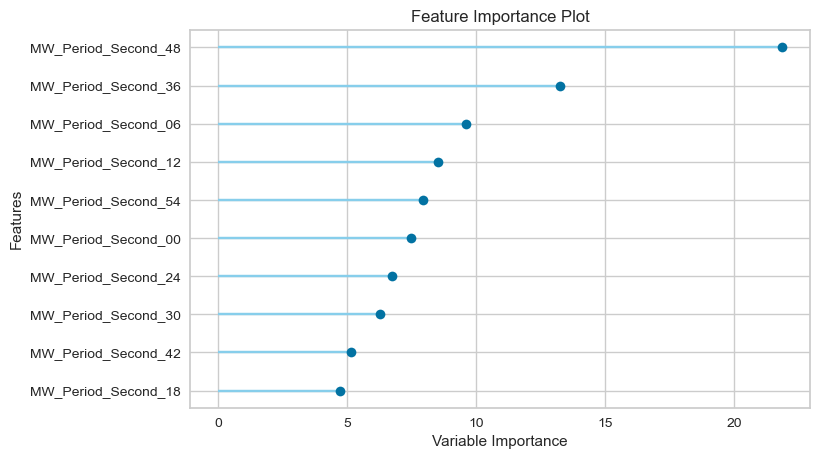

In [22]:
plot_model(model_gbc, plot='feature')

#### ML: Catboost로 진행해보기

- Pycret 자체와 성능 차이를 통해서 ML 방식의 문제점 vs Pycare의 문제점인지 확인
- 참고사이트: https://dacon.io/competitions/official/235863/codeshare/3887?page=1&dtype=recent

In [5]:
SEED = 42
is_holdout = False
n_splits = 5
iterations = 3000
patience = 200

cv = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
cat_features = []

In [14]:
scores = []
models = []


models = []
for tri, vai in cv.split(x_train):
    print("="*50)
    preds = []

    model = CatBoostClassifier(iterations=iterations,random_state=SEED,task_type="CPU",eval_metric="F1",cat_features=cat_features, one_hot_max_size=4)
    model.fit(x_train.iloc[tri], y_train[tri], 
            eval_set=[(x_train.iloc[vai], y_train[vai])], 
            early_stopping_rounds=patience ,
            verbose = 100
        )
    
    models.append(model)
    scores.append(model.get_best_score()["validation"]["F1"])
    if is_holdout:
        break    

Learning rate set to 0.018295
0:	learn: 0.7682356	test: 0.7681881	best: 0.7681881 (0)	total: 23.8ms	remaining: 11m 53s
100:	learn: 0.7689961	test: 0.7690466	best: 0.7693097 (6)	total: 967ms	remaining: 4m 46s
200:	learn: 0.7697359	test: 0.7694677	best: 0.7694677 (157)	total: 1.86s	remaining: 4m 35s
300:	learn: 0.7698702	test: 0.7692176	best: 0.7694677 (157)	total: 2.72s	remaining: 4m 28s
400:	learn: 0.7705438	test: 0.7694680	best: 0.7694680 (388)	total: 3.58s	remaining: 4m 24s
500:	learn: 0.7711636	test: 0.7692044	best: 0.7694680 (388)	total: 4.58s	remaining: 4m 29s
600:	learn: 0.7721898	test: 0.7687554	best: 0.7694680 (388)	total: 5.58s	remaining: 4m 32s
700:	learn: 0.7736478	test: 0.7686625	best: 0.7694680 (388)	total: 6.58s	remaining: 4m 34s
800:	learn: 0.7750990	test: 0.7680399	best: 0.7694680 (388)	total: 7.47s	remaining: 4m 32s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7694680031
bestIteration = 388

Shrink model to first 389 iterations.
Learning rate se

In [15]:
print(scores)
print(np.mean(scores))

threshold = 0.5
pred_list = []
scores = []
for i,(tri, vai) in enumerate( cv.split(x_train) ):
    pred = models[i].predict_proba(x_train.iloc[vai])[:, 1]
    pred = np.where(pred >= threshold , 1, 0)
    score = f1_score(y_train[vai],pred)
    scores.append(score)
    pred = models[i].predict_proba(x_test)[:, 1]
    pred_list.append(pred)
print(scores)
print(np.mean(scores))

pred = np.mean( pred_list , axis = 0 )
pred = np.where(pred >= threshold , 1, 0)

[0.7694680030840402, 0.7632259176288126, 0.7667095667095668, 0.7767188563648741, 0.7710699342498506, 0.7683460647154751, 0.7690592573535718]
0.7692282285865987
[0.7694680030840402, 0.7632259176288126, 0.7667095667095668, 0.7767188563648741, 0.7710699342498506, 0.7683460647154751, 0.7690592573535718]
0.7692282285865987


In [16]:
sample_submission = pd.DataFrame(y_test)
sample_submission['TAG'] = 0
sample_submission['TAG'] = pred

In [17]:
from sklearn.metrics import *
import sklearn.metrics as metrics

y = y_test
p = sample_submission['TAG']

cm = confusion_matrix(y, p)
print(cm)


cm =confusion_matrix(y, p)
print(cm)


acc = accuracy_score(y, p)
print('accuracy_score : ',acc)
print('accuracy', metrics.accuracy_score(y,p) )
print('precision', metrics.precision_score(y,p) )
print('recall', metrics.recall_score(y,p) )
print('f1', metrics.f1_score(y,p) )

print(classification_report(y, p))

[[   39 23736]
 [   23  9322]]
[[   39 23736]
 [   23  9322]]
accuracy_score :  0.2826388888888889
accuracy 0.2826388888888889
precision 0.2819892310484603
recall 0.9975387907972177
f1 0.43968587128269226
              precision    recall  f1-score   support

           0       0.63      0.00      0.00     23775
           1       0.28      1.00      0.44      9345

    accuracy                           0.28     33120
   macro avg       0.46      0.50      0.22     33120
weighted avg       0.53      0.28      0.13     33120



##  1차 결론

- ML가지고 Test 예측하기에는 너무 결과 차이가 심하게 나는 것을 확인할 수 있음 
- 나름 대로의 이유를 생각해보면 결국 ML은 시계열성을 제대로 반영하기 어려움 = 1분 단위 주기 예측이 맞는지도 어려움 
- 추가적으로 regression 이후의 classification 진행하는 방향도 고려 

In [1]:
from pycaret.regression import *

In [6]:
from pycaret.regression import *
reg = setup(data=train,
            target='TAG',
            #numeric_imputation = 'mean',
            #normalize = True,
            #normalize_method = 'zscore',
            #categorical_features = ['age','sex','weekend'],
            silent= True,
            fold_strategy = 'timeseries',
            fold = 5,
            session_id = 0)

,Description,Value
0,session_id,0
1,Target,TAG
2,Original Data,"(50400, 61)"
3,Missing Values,False
4,Numeric Features,50
5,Categorical Features,10
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(35279, 50)"


In [7]:
from sklearn.metrics import *
import sklearn.metrics as metrics
def regression_result(y_true, y_hat):

    y = y_true
    p = y_hat

    cm =confusion_matrix(y, p)
    print(cm)

    acc = accuracy_score(y, p)
    print('accuracy_score : ',acc)
    print('accuracy', metrics.accuracy_score(y,p) )
    print('precision', metrics.precision_score(y,p) )
    print('recall', metrics.recall_score(y,p) )
    print('f1', metrics.f1_score(y,p) )

    print(classification_report(y, p))

In [8]:
best_5_d = compare_models(sort = 'R2', n_select = 3)
print(best_5_d)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.3200,0.1633,0.4040,0.3042,0.0000,0.4205,1.5280
rf,Random Forest Regressor,0.3497,0.1749,0.4177,0.2550,0.0000,0.4578,2.5840
catboost,CatBoost Regressor,0.3847,0.1839,0.4286,0.2164,0.0000,0.5108,2.3120
xgboost,Extreme Gradient Boosting,0.3690,0.1855,0.4301,0.2099,0.0000,0.4800,0.7060
gbr,Gradient Boosting Regressor,0.4192,0.2021,0.4495,0.1391,0.0000,0.5608,1.9220
ada,AdaBoost Regressor,0.4453,0.2217,0.4708,0.0557,0.0000,0.5857,0.4660
br,Bayesian Ridge,0.4583,0.2300,0.4796,0.0202,0.0000,0.6147,0.0440
ridge,Ridge Regression,0.4572,0.2301,0.4796,0.0199,0.0000,0.6130,0.4800
omp,Orthogonal Matching Pursuit,0.4582,0.2303,0.4799,0.0187,0.0000,0.6140,0.0360
lar,Least Angle Regression,0.4571,0.2303,0.4799,0.0187,0.0000,0.6131,0.0360


[ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=0, verbose=0, warm_start=False), RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False), <catboost.core.CatBoostReg

In [9]:
tuned_models = []

model_gbr = create_model('et')

y_hat = list(pd.DataFrame(predict_model(model_gbr)['Label'])['Label'].agg(lambda x: 1 if x >= 0.5 else 0))
y_true = list(predict_model(model_gbr)['TAG'])
regression_result(y_true, y_hat)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.3649,0.1807,0.4251,0.2302,-0.0000,0.4830
1,0.3211,0.1610,0.4013,0.3154,-0.0000,0.4230
2,0.3068,0.1589,0.3987,0.3192,-0.0000,0.4078
3,0.3045,0.1590,0.3988,0.3232,-0.0000,0.4013
4,0.3026,0.1569,0.3961,0.3329,-0.0000,0.3877
Mean,0.3200,0.1633,0.4040,0.3042,0.0000,0.4205
SD,0.0234,0.0088,0.0107,0.0375,0.0000,0.0332


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.2998,0.1562,0.3953,0.3352,0.2772,0.3948


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.2998,0.1562,0.3953,0.3352,0.2772,0.3948


[[7706 1706]
 [2074 3635]]
accuracy_score :  0.7500165332980623
accuracy 0.7500165332980623
precision 0.6805841602696124
recall 0.6367139604133824
f1 0.6579185520361991
              precision    recall  f1-score   support

           0       0.79      0.82      0.80      9412
           1       0.68      0.64      0.66      5709

    accuracy                           0.75     15121
   macro avg       0.73      0.73      0.73     15121
weighted avg       0.75      0.75      0.75     15121



In [10]:
model_lda = create_model('rf') 
y_hat = list(pd.DataFrame(predict_model(model_lda)['Label'])['Label'].agg(lambda x: 1 if x >= 0.5 else 0))
y_true = list(predict_model(model_lda)['TAG'])
regression_result(y_true, y_hat)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4146,0.2076,0.4556,0.1159,-0.0000,0.5497
1,0.3638,0.1776,0.4215,0.2448,-0.0000,0.4731
2,0.3328,0.1656,0.4070,0.2905,-0.0000,0.4392
3,0.3215,0.1623,0.4028,0.3094,-0.0000,0.4231
4,0.3158,0.1613,0.4016,0.3144,-0.0000,0.4042
Mean,0.3497,0.1749,0.4177,0.2550,0.0000,0.4578
SD,0.0365,0.0173,0.0202,0.0737,0.0000,0.0512


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.3080,0.1577,0.3972,0.3288,0.2787,0.4074


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.3080,0.1577,0.3972,0.3288,0.2787,0.4074


[[7775 1637]
 [2179 3530]]
accuracy_score :  0.7476357383770914
accuracy 0.7476357383770914
precision 0.6831817302109542
recall 0.6183219478017166
f1 0.6491357116586981
              precision    recall  f1-score   support

           0       0.78      0.83      0.80      9412
           1       0.68      0.62      0.65      5709

    accuracy                           0.75     15121
   macro avg       0.73      0.72      0.73     15121
weighted avg       0.74      0.75      0.74     15121



In [13]:
model_gbc = create_model('xgboost') #상위 3개 

#model_gbc= tune_model(model_gbc, fold= 5, n_iter = 20, optimize = 'R2', verbose = True, choose_better = True)
#tuned_models.append(model_gbc)

y_hat = list(pd.DataFrame(predict_model(model_gbc)['Label'])['Label'].agg(lambda x: 1 if x >= 0.5 else 0))
y_true = list(predict_model(model_gbc)['TAG'])
regression_result(y_true, y_hat)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.4033,0.2159,0.4647,0.0802,-0.0000,0.5248
1,0.3831,0.1965,0.4433,0.1644,-0.0000,0.4954
2,0.3618,0.1786,0.4226,0.2350,-0.0000,0.4764
3,0.3547,0.1725,0.4153,0.2659,-0.0000,0.4673
4,0.3423,0.1638,0.4047,0.3038,-0.0000,0.4359
Mean,0.3690,0.1855,0.4301,0.2099,0.0000,0.4800
SD,0.0216,0.0186,0.0214,0.0793,0.0000,0.0296


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.3373,0.1615,0.4019,0.3127,0.2819,0.4452


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.3373,0.1615,0.4019,0.3127,0.2819,0.4452


[[8057 1355]
 [2404 3305]]
accuracy_score :  0.7514053303352953
accuracy 0.7514053303352953
precision 0.7092274678111588
recall 0.5789104922052899
f1 0.6374770951875783
              precision    recall  f1-score   support

           0       0.77      0.86      0.81      9412
           1       0.71      0.58      0.64      5709

    accuracy                           0.75     15121
   macro avg       0.74      0.72      0.72     15121
weighted avg       0.75      0.75      0.75     15121



In [14]:
# final 
final_01 = finalize_model(model_gbr) # 단일모델 
final_02 = finalize_model(model_lda) # 
final_03 = finalize_model(model_gbc) # 

value_list = [] # test 용 
for model in [final_01, final_02, final_03]:
    prediction_i = predict_model(model, data = x_test)
    y_pred_i = prediction_i['Label']
    value_list.append(y_pred_i)
    y = y_test
    
predict_table = pd.DataFrame({"index": y_test.index}).set_index('index')
for num, i  in enumerate(value_list):
    predict_table[num] = i 
    
predict_table

final_result = list(pd.DataFrame(np.mean(predict_table, axis = 1)).rename(columns = {0: 'result'})['result'].agg(lambda x: 1 if x >= 0.5 else 0))

In [15]:
from sklearn.metrics import *
import sklearn.metrics as metrics

cm =confusion_matrix(y_test, final_result)
print(cm)

y = y_test
p = final_result

acc = accuracy_score(y_test, final_result)
print('accuracy_score : ',acc)
print('accuracy', metrics.accuracy_score(y,p) )
print('precision', metrics.precision_score(y,p) )
print('recall', metrics.recall_score(y,p) )
print('f1', metrics.f1_score(y,p) )

print(classification_report(y_test, final_result))

[[ 6406  2939]
 [17926  5849]]
accuracy_score :  0.370018115942029
accuracy 0.370018115942029
precision 0.6655666818388711
recall 0.24601472134595162
f1 0.35924208457451706
              precision    recall  f1-score   support

           0       0.26      0.69      0.38      9345
           1       0.67      0.25      0.36     23775

    accuracy                           0.37     33120
   macro avg       0.46      0.47      0.37     33120
weighted avg       0.55      0.37      0.37     33120



In [16]:
from catboost import Pool,CatBoostRegressor

In [17]:
scores = []
models = []


models = []
for tri, vai in cv.split(x_train):
    print("="*50)
    preds = []

    #model = CatBoostClassifier(iterations=iterations,random_state=SEED,task_type="CPU",eval_metric="F1",cat_features=cat_features, one_hot_max_size=4)
    model = CatBoostRegressor(iterations=iterations,random_state=SEED,task_type="CPU",eval_metric="R2",cat_features=cat_features, one_hot_max_size=4)
    
    model.fit(x_train.iloc[tri], y_train[tri], 
            eval_set=[(x_train.iloc[vai], y_train[vai])], 
            early_stopping_rounds=patience ,
            verbose = 100
        )
    
    models.append(model)
    scores.append(model.get_best_score()["validation"]["R2"])
    if is_holdout:
        break    

Learning rate set to 0.011281
0:	learn: 0.0017000	test: 0.0017514	best: 0.0017514 (0)	total: 11.5ms	remaining: 5m 46s
100:	learn: 0.0777083	test: 0.0820137	best: 0.0820137 (100)	total: 589ms	remaining: 2m 54s
200:	learn: 0.1093541	test: 0.1153999	best: 0.1153999 (200)	total: 1.14s	remaining: 2m 48s
300:	learn: 0.1318423	test: 0.1391170	best: 0.1391170 (300)	total: 1.7s	remaining: 2m 47s
400:	learn: 0.1501053	test: 0.1572507	best: 0.1572507 (400)	total: 2.25s	remaining: 2m 46s
500:	learn: 0.1642978	test: 0.1710650	best: 0.1710650 (500)	total: 2.79s	remaining: 2m 44s
600:	learn: 0.1779040	test: 0.1840947	best: 0.1840947 (600)	total: 3.34s	remaining: 2m 43s
700:	learn: 0.1888838	test: 0.1943571	best: 0.1943571 (700)	total: 3.9s	remaining: 2m 42s
800:	learn: 0.1978053	test: 0.2022876	best: 0.2022876 (800)	total: 4.44s	remaining: 2m 41s
900:	learn: 0.2066636	test: 0.2103115	best: 0.2103115 (900)	total: 4.98s	remaining: 2m 40s
1000:	learn: 0.2150443	test: 0.2172818	best: 0.2172818 (1000)	tot

In [18]:
threshold = 0.5
pred_list = []
scores = []
for i,(tri, vai) in enumerate( cv.split(x_train) ):
    pred = models[i].predict(x_train.iloc[vai])
    print(pred)
    pred = np.where(pred >= threshold , 1, 0)
    score = f1_score(y_train[vai],pred)
    scores.append(score)
    pred = models[i].predict(x_test)
    pred_list.append(pred)
print(scores)
print(np.mean(scores))

pred = np.mean( pred_list , axis = 0 )
pred = np.where(pred >= threshold , 1, 0)

[0.71127353 0.64035187 0.75725934 ... 0.39410786 0.39544811 0.46059353]
[0.74057638 0.70209941 0.69429434 ... 0.2736109  0.44379959 0.47608203]
[0.69375789 0.7000661  0.64653994 ... 0.46620231 0.4429445  0.42882582]
[0.69893035 0.77213705 0.76972053 ... 0.34521701 0.4590711  0.53037701]
[0.63979044 0.69093418 0.72624514 ... 0.34908419 0.47249571 0.55511115]
[0.7076335  0.79578701 0.62110997 ... 0.46721635 0.45299755 0.42494088]
[0.62418704 0.70169957 0.64658002 ... 0.45455425 0.3923322  0.36203036]
[0.6589430894308943, 0.642914653784219, 0.6527637173516906, 0.6476897689768976, 0.6495586121946213, 0.6507002232595901, 0.6358357527996682]
0.6483436882567972
